In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from keras import backend as K
import tensorflow as tf
with K.tf.device('/gpu:1'):
    config = tf.ConfigProto(device_count = {'CPU' : 1, 'GPU' : 1})
    session = tf.Session(config=config)
    K.set_session(session)

Using TensorFlow backend.


Split data into train and test set and preview data

## Step3: Data Exploration<a name="step3"></a>

## Step 4: Data Pre-Processing<a name="step4"></a>

In [2]:
import pandas as pd
import logging
import glob
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 500)
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [3]:
#read in data sample 2M rows
traindf, testdf = train_test_split(pd.read_csv('github_issues.csv').sample(n=1000000), 
                                   test_size=.10)


# Data statistics
print(f'Train: {traindf.shape[0]:,} rows {traindf.shape[1]:,} columns')
print(f'Test: {testdf.shape[0]:,} rows {testdf.shape[1]:,} columns')

# Data preview
traindf.head(3)

Train: 900,000 rows 3 columns
Test: 100,000 rows 3 columns


,issue_url,issue_title,body
4017961,"""https://github.com/MoOx/postcss-cssnext/issues/423""",replace postcss-nesting to postcss-nested,replace postcss-nesting with postcss-nested https://github.com/postcss/postcss-nested because of the second one is more powerful.
1217222,"""https://github.com/cal-wilkes/waveform_jenny-/issues/15""",create triangle wave generator,this module will take in input from the signals freq produced by the frequency counter module and amp produced by the amplitude counter module. this module will also be supplied by the clock signal to allow for synchronous operation and a reset signal to allow for a system reset.
477951,"""https://github.com/Sym123Blue/GitHubQAAutomation37dce3ec-9a11-4271-b461-dc301665815b/issues/1""",github automation for issue title 37dce3ec-9a11-4271-b461-dc301665815b,github automation for issue body 37dce3ec-9a11-4271-b461-dc301665815b


Keep English Language Title only

In [4]:
#traindf
eng_rec = list()
for i in range(len(traindf)):
    temp_ord = ord(traindf.iloc[i,:].issue_title[0])
    if((temp_ord >= ord('a') and temp_ord <= ord('z'))
       or(temp_ord >= ord('A') and temp_ord <= ord('Z'))or(temp_ord >= ord('0') and temp_ord <= ord('9'))): 
        eng_rec.append(i)
traindf = traindf.iloc[eng_rec]
#testdf
eng_rec = list()
for i in range(len(testdf)):
    temp_ord = ord(testdf.iloc[i,:].issue_title[0])
    if((temp_ord >= ord('a') and temp_ord <= ord('z'))
       or(temp_ord >= ord('A') and temp_ord <= ord('Z'))or(temp_ord >= ord('0') and temp_ord <= ord('9'))): 
        eng_rec.append(i)
testdf = testdf.iloc[eng_rec]

**Convert to lists in preparation for modeling**

In [26]:
train_body_raw = traindf.body.tolist()
train_title_raw = traindf.issue_title.tolist()

In [27]:
%reload_ext autoreload
%autoreload 2
from ktext.preprocess import processor

In [28]:
# Clean, tokenize, and apply padding / truncating to make the length of each document the same(70)
# Only use the top 8,000 words in the vocabulary and set the remaining words to 1 which will stand for the index for rare words 
body_pp = processor(keep_n=8000, padding_maxlen=70)
train_body_vecs = body_pp.fit_transform(train_body_raw)

#### Processed issue body example

In [29]:
print('\noriginal string:\n', train_body_raw[0], '\n')
print('after pre-processing:\n', train_body_vecs[0], '\n')


original string:
 replace postcss-nesting with postcss-nested https://github.com/postcss/postcss-nested because of the second one is more powerful. 

after pre-processing:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0  777
 4187 6408   18 4187 1898   13  158   11    3  555   68    8   97 5464] 



In [30]:
# Instantiate a text processor for the titles, with some different parameters
#  append_indicators = True appends the tokens '_start_' and '_end_' to each
#                      document
#  padding = 'post' means that zero padding is appended to the end of the 
#             of the document (as opposed to the default which is 'pre')
title_pp = processor(append_indicators=True, keep_n=4500, 
                     padding_maxlen=12, padding ='post')

# process the title data
train_title_vecs = title_pp.fit_transform(train_title_raw)

#### Processed issue title example

In [31]:
print('\noriginal string:\n', train_title_raw[0])
print('after pre-processing:\n', train_title_vecs[0])


original string:
 replace postcss-nesting to postcss-nested
after pre-processing:
 [   2  403 4118 4020    4 4118  758    3    0    0    0    0]


Dump the body and title data for later use

In [32]:
import dill as dpickle
import numpy as np

# Save the preprocessor
with open('body_pp1.dpkl', 'wb') as f:
    dpickle.dump(body_pp, f)

with open('title_pp1.dpkl', 'wb') as f:
    dpickle.dump(title_pp, f)

# Save the processed data
np.save('train_title_vecs1.npy', train_title_vecs)
np.save('train_body_vecs1.npy', train_body_vecs)

## Step5: Data Analysis<a name="step5"></a>

### Load the data from disk into variables<a name="load_data"></a>

In [33]:
from seq2seq_utils import load_decoder_inputs, load_encoder_inputs, load_text_processor

In [34]:
encoder_input_data, doc_length = load_encoder_inputs('train_body_vecs1.npy')
decoder_input_data, decoder_target_data = load_decoder_inputs('train_title_vecs1.npy')

Shape of encoder input: (882034, 70)
Shape of decoder input: (882034, 11)
Shape of decoder target: (882034, 11)


In [35]:
num_encoder_tokens, body_pp = load_text_processor('body_pp1.dpkl')
num_decoder_tokens, title_pp = load_text_processor('title_pp1.dpkl')

Size of vocabulary for body_pp1.dpkl: 8,002
Size of vocabulary for title_pp1.dpkl: 4,502


### Define Model Architecture<a name="model"></a>

In [49]:
%matplotlib inline
from keras.models import Model
from keras.layers import Input, GRU, Dense, Embedding, BatchNormalization
from keras import optimizers

#### Encoder<a name="encoder"></a>
The encoder consists of a word embedding layer for the issue body vectors, a batch normalization layer for the embedding layer and a Gated Recurrent Unit layer. 

In [50]:
# embedding and hidden units dimension
latent_dim = 300
encoder_inputs = Input(shape=(doc_length,), name='Encoder-Input')

# Word embeding Layer
x = Embedding(num_encoder_tokens, latent_dim, name='Body-Word-Embedding', mask_zero=False)(encoder_inputs)
# Batch Normalization Layer
x = BatchNormalization(name='Encoder-Batchnorm-1')(x)

# Get the hidden state of the GRU
_, state_h = GRU(latent_dim, return_state=True, name='Encoder-Last-GRU')(x)

# Encapsulate the encoder
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')

# Get output of the encoder
seq2seq_encoder_out = encoder_model(encoder_inputs)

#### Decoder <a name="decoder"></a>
The decoder consists of an embedding layer for the issue title vectors, a batch normalization layer for the embedding layer, a Gated Recurrent Unit(GRU) layer, a batch normalization layer for the GRU layer and finally, a densely connected layer for the final output. 

In [51]:
decoder_inputs = Input(shape=(None,), name='Decoder-Input')  # for teacher forcing

# Decoder Word Embedding Layer
dec_emb = Embedding(num_decoder_tokens, latent_dim, name='Decoder-Word-Embedding', mask_zero=False)(decoder_inputs)
# Batch Normalization Layer
dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)

# Set up the decoder, using `decoder_state_input` as initial state.
decoder_gru = GRU(latent_dim, return_state=True, return_sequences=True, name='Decoder-GRU')
decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=seq2seq_encoder_out)
x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_gru_output)

# Dense layer for prediction
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='Final-Output-Dense')
decoder_outputs = decoder_dense(x)

#### Model Compilation<a name="compile"></a>
The initial 
Nadam optimizer was chosen because...
We choose to use the sparse categorical crossentropy because...

In [52]:
#### Seq2Seq Model ####
seq2seq_Model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
seq2seq_Model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')

#### Examine Model Architecture Summary <a name="summary"></a>
From the model visualization we can better understand the architecture of this model: <br>
The model generates a single word forecast and calls it recursively. <br>

That is, the decoder uses the context vector and the distributed representation of all words generated so far as input in order to generate the next word.<br>

A language model can be used to interpret the sequence of words generated so far to provide a second context vector to combine with the representation of the source document in order to generate the next word in the sequence.<br>

The summary is built by recursively calling the model with the previously generated word appended.<br>




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 300)    1350600     Decoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      (None, 70)           0                                            
__________________________________________________________________________________________________
Decoder-Batchnorm-1 (BatchNorma (None, None, 300)    1200        Decoder-Word-Embedding[0][0]     
__________________________________________________________________________________________________
Encoder-Mo

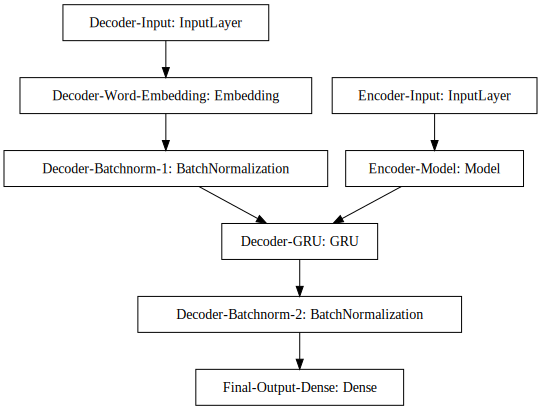

In [53]:
from seq2seq_utils import viz_model_architecture
seq2seq_Model.summary()
viz_model_architecture(seq2seq_Model)

#### Train Model<a name="train"></a>

In [55]:
from keras.callbacks import CSVLogger, ModelCheckpoint

script_name_base = 'tutorial_seq2seq'
csv_logger = CSVLogger('{:}.log'.format(script_name_base))
model_checkpoint = ModelCheckpoint('{:}.epoch{{epoch:02d}}-val{{val_loss:.5f}}.hdf5'.format(script_name_base),
                                   save_best_only=True)

batch_size = 1200
epochs = 5
history = seq2seq_Model.fit([encoder_input_data, decoder_input_data], np.expand_dims(decoder_target_data, -1),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.12, callbacks=[csv_logger, model_checkpoint])

Train on 776189 samples, validate on 105845 samples
Epoch 1/5
776189/776189 [==============================] - 107s 138us/step - loss: 2.5401 - val_loss: 2.4854


/home/shirley/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer Decoder-GRU was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'Encoder-Model_2/Encoder-Last-GRU/while/Exit_3:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/5
776189/776189 [==============================] - 105s 136us/step - loss: 2.3526 - val_loss: 2.4395
Epoch 3/5
776189/776189 [==============================] - 102s 131us/step - loss: 2.2588 - val_loss: 2.4259
Epoch 4/5
776189/776189 [==============================] - 162s 209us/step - loss: 2.1947 - val_loss: 2.4238
Epoch 5/5
776189/776189 [==============================] - 112s 144us/step - loss: 2.1444 - val_loss: 2.4333


In [56]:
#save model
seq2seq_Model.save('seq2seq_model_tutorial1.h5')

#### See Results On Test Set<a name="examples"></a>

1. To predict the issue titles with our model, we wrote a script that extracts the encoder model  and decoder model, then predicts the title sequence word by word with the models. 
2. From the examples, we can see that the titles generated by our model are similar to the original titles. 

In [57]:
from seq2seq_utils import Seq2Seq_Inference
seq2seq_inf = Seq2Seq_Inference(encoder_preprocessor=body_pp,
                                 decoder_preprocessor=title_pp,
                                 seq2seq_model=seq2seq_Model)

In [60]:
# choose 5 examples randomly from the test set
seq2seq_inf.demo_model_predictions(n=5, issue_df=testdf)

Example # 44372
Issue Body:
 compiled code doesn't seem to recognize keyword arguments. minimal example: hello.py def aaa thing=3 : print thing def bbb a : aaa aaa a aaa thing=a hello.html <script src= __javascript__/hello.js ></script> <script type= text/javascript > hello.bbb 1 ; </script> this produces output 3 1 3 , whereas in python bbb 1 obviously gives 3 1 1 . i compile this with transcrypt -b -m hello.py . i installed transcrypt with pip, my python version: python 3.6.3 |anaconda, inc.| default, oct 13 2017, 12:02:49 gcc 7.2.0 on linux why does it happen? 

Original Title: keyword arguments are ignored.

****** Machine Generated Title (Prediction) ******: arguments to keyword arguments

Example # 94207
Issue Body:
 i cannot get to build the project with xcode 9.2 and swift4, i get a warning on autokbisw that tells me to conver to swift4 and the error below> ! schermata 2017-12-13 alle 13 45 24 https://user-images.githubusercontent.com/26550959/33939634-37415246-e00c-11e7-8749-0

#### ROUGE Scores <a name="rouge"></a>
ROUGE is a recall-oriented package for Automatic Evaluation of machine generated summaries. <br>
The algorithms of ROUGE scores are presented as follows. <br>

<hr>
$$
P_{l c s}=\frac{L C S(X, Y)}{n}
$$

$$
R_{l c s}=\frac{L C S(X, Y)}{m}
$$

$$
F_{l c s}=\frac{\left(1+\beta^{2}\right) R_{l c s} P_{l c s}}{R_{l c s}+\beta^{2} P_{l c s}}(4)
$$



In [65]:
# Import the ROUGE Package
from rouge import Rouge

rouge = Rouge()

test_title_text = testdf.issue_title.tolist()
test_body_text = testdf.body.tolist()
predict_title_text = [None]*len(test_body_text)
rouge_1_f, rouge_2_f, rouge_l_f = 0, 0, 0

length = len(test_body_text)

# Generate the title for each issue body
for i in range(length):
    exm, predict_title_text[i] = seq2seq_inf.generate_issue_title(raw_input_text=test_body_text[i])
    if i%1000==0:
        print(i)
        
def calculate_rouge():
    rouge_1_f, rouge_2_f, rouge_l_f = 0, 0, 0
    for i in range(length):
        # The rouge package does not accept empty strings 
        if predict_title_text[i]=="":
            predict_title_text[i] = "issue"
            
        scores = rouge.get_scores(predict_title_text[i], test_title_text[i])
        rouge_1_f = rouge_1_f + scores[0]['rouge-1']['f']
        rouge_2_f = rouge_2_f + scores[0]['rouge-2']['f']
        rouge_l_f = rouge_l_f + scores[0]['rouge-l']['f']
        
        if i%1000==0:
            print("ROUGE-l-f:", rouge_l_f)
        
    print("ROUGE-1:", rouge_1_f / len(test_body_text))
    print("ROUGE-2:", rouge_2_f / len(test_body_text))
    print("ROUGE-l:", rouge_l_f / len(test_body_text))
    print("Average of ROUGE-1, ROUGE-2 and ROUGE-l: ", (rouge_1_f + rouge_2_f + rouge_l_f) / 3 / len(test_body_text))

calculate_rouge()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
ROUGE-l-f: 0.0
ROUGE-l-f: 181.297584877275
ROUGE-l-f: 376.7957096457366
ROUGE-l-f: 567.3355183080444
ROUGE-l-f: 747.2491250976716
ROUGE-l-f: 942.315243429852
ROUGE-l-f: 1135.9542131118494
ROUGE-l-f: 1333.1688210936354
ROUGE-l-f: 1524.860930882192
ROUGE-l-f: 1720.2050039483654
ROUGE-l-f: 1909.3125374956046
ROUGE-l-f: 2112.474692861815
ROUGE-l-f: 2294.641018573923
ROUGE-l-f: 2488.0898485973808
ROUGE-l-f: 2675.21798913